<a href="https://colab.research.google.com/github/VIVEK-JADHAV/TweetSentimentExtraction/blob/master/CaseStudy2ManyToMany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import re 
import string
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,Embedding,Lambda,Dropout,LSTM,Conv1D,TimeDistributed
from tensorflow.keras.models import Model
import time
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Creating a folder to store train and test data
import os
os.mkdir('/content/data')
%cd /content/data/
!pwd

/content/data
/content/data


In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 86.0MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 41.6MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 74.7MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#Loading the train dataset

train=pd.read_csv('/content/data/train.csv')
print('Shape of the train data is ',train.shape)
train.head()

Shape of the train data is  (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
#Loading the test dataset

test=pd.read_csv('/content/data/test.csv')
print('Shape of the test data is ',test.shape)
test.head()

Shape of the test data is  (3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
#Dropping the row with null value
train.dropna(inplace=True)
train.reset_index(inplace=True,drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train[['sentiment','text','textID']],train['selected_text'],
                                               test_size=0.2,random_state=42,stratify=train['sentiment'])

X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])
X_train.drop(8119,axis=0,inplace=True)
X_test.drop(26004,axis=0,inplace=True)

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train.drop(8119,axis=0,inplace=True)
Y_test.drop(26004,axis=0,inplace=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train shape',X_train.shape,' Y_train shape ',Y_train.shape)
print('X_val shape',X_val.shape,' Y_val shape ',Y_val.shape)
print('X_test shape',X_test.shape,' Y_test shape ',Y_test.shape)

X_train shape (17586, 3)  Y_train shape  (17586,)
X_val shape (5496, 3)  Y_val shape  (5496,)
X_test shape (4396, 3)  Y_test shape  (4396,)


In [ ]:
seq_length=32

In [ ]:
#Tokenizing the clean_text and sentiment and mapping each word to a integer followed by padding to have equal lengths

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=1)
tokenizer.fit_on_texts(X_train['text'].values)

X_train_text = tokenizer.texts_to_sequences(X_train['text'].values)
X_val_text = tokenizer.texts_to_sequences(X_val['text'].values)
X_test_text = tokenizer.texts_to_sequences(X_test['text'].values)

Y_train_text = tokenizer.texts_to_sequences(Y_train.values)
Y_val_text = tokenizer.texts_to_sequences(Y_val.values)
Y_test_text = tokenizer.texts_to_sequences(Y_test.values)



X_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_train_text,maxlen=seq_length,padding='post')
X_val_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_val_text,maxlen=seq_length,padding='post')
X_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_test_text,maxlen=seq_length,padding='post')

Y_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(Y_train_text,maxlen=seq_length,padding='post')
Y_val_tokens = tf.keras.preprocessing.sequence.pad_sequences(Y_val_text,maxlen=seq_length,padding='post')
Y_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(Y_test_text,maxlen=seq_length,padding='post')

print('The shape of X_train_tokens ',X_train_tokens.shape)
print('The shape of X_val_tokens ',X_val_tokens.shape)
print('The shape of X_test_tokens ',X_test_tokens.shape)
print('*'*50)
print('The shape of Y_train_tokens ',Y_train_tokens.shape)
print('The shape of Y_val_tokens ',Y_val_tokens.shape)
print('The shape of Y_test_tokens ',Y_test_tokens.shape)

The shape of X_train_tokens  (17586, 32)
The shape of X_val_tokens  (5496, 32)
The shape of X_test_tokens  (4396, 32)
**************************************************
The shape of Y_train_tokens  (17586, 32)
The shape of Y_val_tokens  (5496, 32)
The shape of Y_test_tokens  (4396, 32)


In [ ]:
#Create mask layer
def create_mask(X):
  X_mask=np.zeros((X.shape[0],32))
  for i in tqdm(range(X.shape[0])):
    for j in range(len(X[i])):
      if( X[i,j]!=0):
        X_mask[i,j]=1
  return X_mask

In [ ]:
X_train_mask=create_mask(X_train_tokens)
X_val_mask=create_mask(X_val_tokens)
X_test_mask=create_mask(X_test_tokens)

print('The shape of X_train_mask ',X_train_mask.shape)
print('The shape of X_val_mask ',X_val_mask.shape)
print('The shape of X_test_mask ',X_test_mask.shape)

100%|██████████| 4396/4396 [00:00<00:00, 15247.12it/s]

The shape of X_train_mask  (17586, 32)
The shape of X_val_mask  (5496, 32)
The shape of X_test_mask  (4396, 32)


In [ ]:
def create_y_data(X,Y):
  '''Creates target variable'''
#Insert 1 in the label vector if selected text token is present in text tokens else 2 with 0 as padded token

  labels=np.zeros_like(X)
  for i in tqdm(range(X.shape[0])):    
    k=0    
    for j in Y[i]:
      if(j not in X[i]):        
        continue
      if(j==0):
        break
      while (X[i][k]!=0):              
        if(j==X[i][k]):
          labels[i,k]=1
          k+=1
          break
        else:          
          k+=1
  return labels
        


In [ ]:
#Create target variable and expand to 3D as output from modelis 3D
Y_tr=create_y_data(X_train_tokens,Y_train_tokens)
Y_tr=np.expand_dims(Y_tr,-1)

Y_va=create_y_data(X_val_tokens,Y_val_tokens)
Y_va=np.expand_dims(Y_va,-1)

Y_te=create_y_data(X_test_tokens,Y_test_tokens)
Y_te=np.expand_dims(Y_te,-1)


100%|██████████| 4396/4396 [00:00<00:00, 11620.80it/s]


In [ ]:
X_train_tokens[88]

array([1536,    4,  961,   16, 7906,  664,   50, 5274,  325,  496,   40,
        321,    9,    4, 5275,  128,  800, 2885,   39, 1786, 7907,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
Y_train_tokens[88]

array([5275,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
Y_tr[88]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

20120


In [ ]:
#Reference https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-09-08 12:48:53--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-09-08 12:48:53--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-09-08 12:48:53--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip /content/data/glove.twitter.27B.zip

Archive:  /content/data/glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  

In [ ]:
#Loading all the vectors as dictonary with key as string and value as vector

embeddings_index = {}
f = open('/content/data/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
#Getting the weights from the above dictionary for all the words in the document

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:    
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(20120, 100)

In [ ]:
#Model Archietecture

#Input Layer
input_layer=Input((seq_length,),name='input')
input_mask=Input((seq_length,),name='input_mask')

#Embedding layer
embedding_layer=Embedding(vocab_size,100,input_length=seq_length,weights=[embedding_matrix],trainable=False,mask_zero=True)(input_layer)

#Encoder
lstm=LSTM(32,name='lstm',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=30),return_sequences=True)(embedding_layer)
                
output=TimeDistributed(Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),
             name='output'))(lstm,input_mask)

model=Model(inputs=[input_layer,input_mask],outputs=[output])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 100)      2012000     input[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32, 32)       17024       embedding[0][0]                  
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 32)]         0                                            
_______________________________________________________________________________________

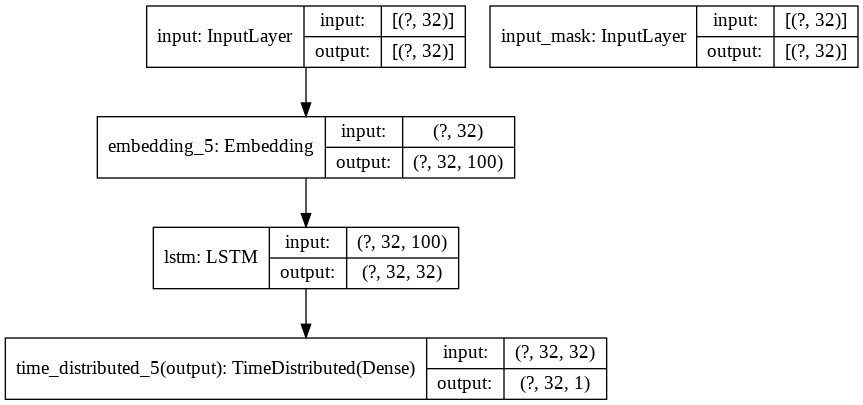

In [ ]:
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

Model Archietecture
* Input layer: Token ids of the tweet is given as input
* Mask layer: This layer is masking the padded tokens
* Embedding Layer: Each token id is converted to 100 D vector using the pretrained Glove vector.
* LSTM: The LSTM layer returns output at each time sequence.
* Time distributed Dense Layer: This layer takes LSTM output at every time sequence and predicts whether the token must be present in the selected_text or not.

In [ ]:
#Creating  directory for model and weights 
import os
import shutil

# shutil.rmtree('/content/Model')
# shutil.rmtree('/content/model_save')

os.mkdir('/content/Model2')
os.mkdir('/content/model_save2')

In [ ]:
#Setting the parameters for TensorBoard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf ./logs/ 

log_dir='/content/Model2'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [ ]:
# Save  model at every epoch
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="/content/model_save2/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
# loss function
loss_object = tf.keras.losses.BinaryCrossentropy(
    reduction='none')

def loss_function(real, pred): 
  '''Computes the loss for each token and takes the mean'''
  real=tf.squeeze(real)
  pred=tf.squeeze(pred)    

  final_loss=0
  #Iterating over each of batch elements
  for i in range(real.shape[0]):    

    r=tf.reshape(real,[-1,1])
    p=tf.reshape(pred[i],[-1,1])

    #Computing loss for each of token elements.
    loss_ = loss_object(r, p)

    #Taking mean of all the losses
    loss_=tf.reduce_mean(loss_)

    #Summing all the losses for batch datapoints 
    final_loss+=loss_
    
  #Returning mean of all batch points
  return final_loss/real.shape[0]

In [ ]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_function)

In [ ]:
#Fitting the model and running it for 10 epochs
callback=[tensorboard_callback,checkpoint]
model.fit([X_train_tokens,X_train_mask],Y_tr,batch_size=32,epochs=11,callbacks=callback,
           validation_data=([X_val_tokens,X_val_mask],Y_va))

Epoch 1/11
  1/550 [..............................] - ETA: 0s - loss: 0.2914WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
550/550 [==============================] - ETA: 0s - loss: 0.2598
Epoch 00001: val_loss improved from inf to 0.23305, saving model to /content/model_save2/weights-01-0.2330.hdf5
550/550 [==============================] - 154s 280ms/step - loss: 0.2598 - val_loss: 0.2330
Epoch 2/11
550/550 [==============================] - ETA: 0s - loss: 0.2132
Epoch 00002: val_loss improved from 0.23305 to 0.19707, saving model to /content/model_save2/weights-02-0.1971.hdf5
550/550 [==============================] - 155s 283ms/step - loss: 0.2132 - val_loss: 0.1971
Epoch 3/11
550/550 [==============================] - ETA: 0s - loss: 0.1838
Epoch 00003:

In [ ]:
%tensorboard --logdir '/content/Model'

In [ ]:
#Load weights having lowest val_loss
model.load_weights('/content/model_save2/weights-11-0.1258.hdf5')

In [ ]:
def jaccard(str1, str2):
  '''Returns jaccard score between str1 and str2 '''
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#Predicting on test data
Y_pred_test=model.predict([X_test_tokens,X_test_mask])
Y_pred_test=np.squeeze(Y_pred_test)
Y_te=np.squeeze(Y_te)
print('Y_pred_test shape is ',Y_pred_test.shape)

Y_pred_test shape is  (4396, 32)


In [ ]:
#Actual Y value
Y_te[90]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
#Replacing value 2 back to zero

Y_te=np.where(Y_te==2,0,Y_te)

In [ ]:
Y_te[90]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
#Predicted Y value
Y_pred_test[90]

array([0.27357224, 0.5480001 , 0.40082967, 0.3899384 , 0.18752205,
       0.07624662, 0.237461  , 0.03192362, 0.03192362, 0.03192362,
       0.03192362, 0.03192362, 0.03192362, 0.03192362, 0.03192362,
       0.03192362, 0.03192362, 0.03192362, 0.03192362, 0.03192362,
       0.03192362, 0.03192362, 0.03192362, 0.03192362, 0.03192362,
       0.03192362, 0.03192362, 0.03192362, 0.03192362, 0.03192362,
       0.03192362, 0.03192362], dtype=float32)

In [ ]:
#Set value=1 for position of words whose value is greater than 0.1 else 0

from tqdm import tqdm

def predict(Y_pred):
  '''Set value=1 for position of words whose value is greater than 0.1 else 0'''
  prediction=[]
  for row in tqdm(Y_pred):
    lst=[]
    for i in range(len(row)):
      if(row[i]>0.1):
        lst.append(1)
      else:
        lst.append(0)
    prediction.append(lst)
  return prediction




In [ ]:
def findLongestSequence(prediction):
  #Dictionary that stores index with 1 as key and number of contineous 1 as value
  #Eg:[11110011] d={0:4,1:3,2:2,3:1,6:2,7:1}
  d={}  
  for i in range(len(prediction)):   
    #If value is 0, continue the loop
    if(prediction[i]==0):
      continue
    else:
      j=i+1
      k=0
      #Update the dictionary for first time
      d[i]=1
      while ((k==0) & (j<len(prediction))):
        
        if (prediction[j]==1):
          #Update the dictionary for every time when j position is 1
          d[i]=d[i]+1
          j+=1
        else:
          k=1      
  #m stores max value of number of 1
  m=0
  start=0
  #Iterating over dictionary to find key with max 1 which is the start index
  for k,v in d.items():
    if (v>m):
      m=v
      start=k
  #End postion is start + value coressponding to start key
  end=start+d[start]
  return start,end


In [ ]:
#Extracting the text from the tweet based on above indices
def predictText(prediction):
  predicted_text=[]
  for row in tqdm (range(len(prediction))):
    
    if ((sum((prediction[row]))==0)):
      t=" ".join(X_test.loc[row,'text'].split())
    else:
      start,end=findLongestSequence(prediction[row])     
      t=" ".join(X_test.loc[row,'text'].split()[start:end+1])
    predicted_text.append(t)
  return predicted_text

In [ ]:
#Calculating jaccard score
def calculateJaccard(predicted_text,Y_test):
  jaccard_score=[]
  for i in tqdm(range(len(predicted_text))):
    score=jaccard(predicted_text[i],Y_test[i])
    jaccard_score.append(score)
  return jaccard_score

In [ ]:
#Calculate number of queries per second
import time

def calculateTime(X_tokens,X_mask,Y_actual):
  start=time.time()
  Y_pred_test=model.predict([X_tokens,X_mask])
  Y_pred_test=np.squeeze(Y_pred_test)

  #Convert probability to 0 and 1
  prediction=predict(Y_pred_test)

  #Find the predicted text
  predicted_text=predictText(prediction)

  #Compute Jaccard score
  jaccard_score=calculateJaccard(predicted_text,Y_actual)

  end=time.time()

  diff=end-start

  print('Time difference is ',diff)

  return jaccard_score,diff,predicted_text

  



In [ ]:
print('The number of queries is ',X_test_tokens.shape[0])
result,time_diff,predicted_text=calculateTime(X_test_tokens,X_test_mask,Y_test)

The number of queries is  4396


100%|██████████| 4396/4396 [00:00<00:00, 48450.71it/s]

Time difference is  7.251146078109741


In [ ]:
total=X_test_tokens.shape[0]/time_diff
print('Number of queries executed by the model in 1 second is ',total)

Number of queries executed by the model in 1 second is  606.2489919036312


In [ ]:
np.mean(result)

0.5820691670650979

**Queries per second**
* The model exceutes 2742 queries per second.

In [ ]:
X_test['predicted_text']=predicted_text
X_test['selected_text']=Y_test
X_test['jaccard']=result
X_test.head(10)

,sentiment,text,textID,predicted_text,selected_text,jaccard
0,negative,misses driving already,197aa929a2,misses driving already,misses driving already,1.000000
1,positive,Name the rest? Let`s see. Mystery Jets are pr...,7648a76c96,Name the rest? Let`s see. Mystery Jets are pre...,cool.,0.071429
2,neutral,anyways have a severe headache ryt now! i jst...,14fc34a4fb,anyways have a severe headache ryt now! i jst ...,anyways have a severe headache ryt now! i jst ...,1.000000
3,neutral,25-man Ulduar is hard...,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,1.000000
4,negative,Cried Like A Fukn Baby Today Durin Da Senior S...,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,0.071429
5,positive,Not a prob hun,6649f3558c,Not a prob hun,Not a prob,0.750000
6,positive,"I know It was worth a shot, though!",a54d3c2825,"I know It was worth a shot, though!",as wort,0.000000
7,neutral,You`re still welcome - the door`s wide enough...,db83ff224e,You`re still welcome - the door`s wide enough ...,You`re still welcome - the door`s wide enough ...,1.000000
8,positive,"_nickj07 Um....Nicks Voice,Smile,Eyes,Laugh,an...",fdbaccd945,"_nickj07 Um....Nicks Voice,Smile,Eyes,Laugh,an...",Great,0.142857
9,neutral,reminds me of the weather a month ago it was ...,1c82fa1e65,reminds me of the weather a month ago it was h...,reminds me of the weather a month ago it was h...,1.000000


##### Error Analysis

In [ ]:
#Average Jaccard score for each sentiment

pos_average=np.mean(X_test['jaccard'][X_test['sentiment']=='positive'])
print('The average jaccard score for postive sentiment is  ',pos_average)

neg_average=np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('The average jaccard score for negative sentiment is  ',neg_average)

neu_average=np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('The average jaccard score for neutral sentiment is  ',neu_average)

The average jaccard score for postive sentiment is   0.31054370494645167
The average jaccard score for negative sentiment is   0.3322234244713896
The average jaccard score for neutral sentiment is   0.9726760063600768


In [ ]:
#Adding len of the selected text column

X_test['len_selected_text']=X_test['selected_text'].apply(lambda x: len(x.split()))
X_test['len_text']=X_test['text'].apply(lambda x: len(x.split()))
X_test['diff_len']=abs(X_test['len_selected_text']-X_test['len_text'])
X_test.head()

,sentiment,text,textID,predicted_text,selected_text,jaccard,len_selected_text,len_text,diff_len
0,negative,misses driving already,197aa929a2,misses driving already,misses driving already,1.000000,3,3,0
1,positive,Name the rest? Let`s see. Mystery Jets are pr...,7648a76c96,Name the rest? Let`s see. Mystery Jets are pre...,cool.,0.055556,1,20,19
2,neutral,anyways have a severe headache ryt now! i jst...,14fc34a4fb,anyways have a severe headache ryt now! i jst ...,anyways have a severe headache ryt now! i jst ...,1.000000,24,24,0
3,neutral,25-man Ulduar is hard...,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,1.000000,4,4,0
4,negative,Cried Like A Fukn Baby Today Durin Da Senior S...,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,0.071429,1,15,14


In [ ]:
#Total number of tweets with correct prediction and incorrect prediction
pos_jac_1=X_test[X_test['jaccard']==1]
pos_jac_0=X_test[X_test['jaccard']!=1]

In [ ]:
print('The total number of  tweets is',X_test.shape[0])
print('The total number of  tweets with jaccard=1 is',pos_jac_1.shape[0])
print('The total number of  tweets with jaccard not 1 is',pos_jac_0.shape[0])

The total number of  tweets is 4396
The total number of  tweets with jaccard=1 is 1900
The total number of  tweets with jaccard not 1 is 2496


In [ ]:
#Performance of model when both tweet and selected text is same

total_zero_diff=X_test[X_test['diff_len']==0].shape[0]
zero_diff_jaccard_1=pos_jac_1[pos_jac_1['diff_len']==0].shape[0]
result=zero_diff_jaccard_1*100/total_zero_diff
print('The percentage of  tweets with jaccard=1 when both tweet and selected text were same is',result)

The percentage of  tweets with jaccard=1 when both tweet and selected text were same is 94.41953163926259


In [ ]:
#Performance of model when difference between  tweet and selected text is less than 10

diff_less_10=X_test[X_test['diff_len']<=10].shape[0]
diff_less_10_jaccard_1=pos_jac_1[pos_jac_1['diff_len']<=10].shape[0]
result=diff_less_10_jaccard_1*100/diff_less_10
print('The percentage of tweets with jaccard=1 when length difference is less than 10 is',result)

The percentage of tweets with jaccard=1 when length difference is less than 10 is 58.07339449541284


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 10 but less than 20

diff_less_20=X_test[(X_test['diff_len']>10) & (X_test['diff_len']<=20)].shape[0]
diff_less_20_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>10) & (pos_jac_1['diff_len']<=20)].shape[0]
result=diff_less_20_jaccard_1*100/diff_less_20
print('The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is',result)

The percentage of tweets with jaccard=1 when length difference is greter than 10 and less than 20 is 0.1122334455667789


In [ ]:
#Performance of model when difference between  tweet and selected text is greter than 20

diff_less_30=X_test[(X_test['diff_len']>20)].shape[0]
diff_less_30_jaccard_1=pos_jac_1[(pos_jac_1['diff_len']>20)].shape[0]
result=diff_less_30_jaccard_1*100/diff_less_30
print('The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is',result)

The percentage of positive tweets with jaccard=1 when length difference is greter than 20 is 0.0


In [ ]:
print(np.mean(X_test['jaccard']))

0.5844887647103213


Conclusion
* The  model performs well when the text and selected text are of same length.
* It does resonablly well when the difference between tweet selected text is of only few words but does not perform well when the difference increases.